In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
# do sentiment analysis using VADER
# doesn't seem to be accurate reading finanical news
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentence = "AstraZeneca profit down as sales of stalwarts fade"
sia = SentimentIntensityAnalyzer()
ss = sia.polarity_scores(sentence)
print(sentence)
print(ss)


AstraZeneca profit down as sales of stalwarts fade
{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.4404}


In [5]:
# train a model using financial dataset
import pandas as pd
data_df=pd.read_csv('./fin_sentiment.csv')
data_df.head()


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [6]:
# tokenize text, only tokenize words
import nltk.tokenize as tk

def tokenizer(text):
    return tk.regexp_tokenize(text.lower(), r'[^a-zA-Z]+', gaps=True)

sentences = data_df['Sentence'].apply(tokenizer)
raw_sentences=data_df['Sentence']
max_length = 0
for sentence in sentences:
    if len(sentence)>max_length:
        max_length=len(sentence)
print(max_length)

50


In [7]:
# word2vec for DL
import gensim
vec_model = gensim.models.Word2Vec(window=5,min_count=10) # each vector 100 dimension by default
vec_model.build_vocab(sentences)
vec_model.train(sentences,total_examples=vec_model.corpus_count,epochs=100)

(5997186, 10638500)

In [9]:
filler = [0 for i in range(100)]

In [10]:

import numpy as np
X=[]
# 5864 sentences, each sentences have 50 words, each word has a 100d vector
# shape(x) = (5864,50,100)
for sentence in sentences:
    word_vec=[] # each word has a word vector
    for word in sentence:
        if word in vec_model.wv:
            word_vec.append(vec_model.wv[word].tolist())
        else: word_vec.append(filler)
    # pad shorter sentence
    for shorter_amount in range((max_length-len(sentence))):
        word_vec.append(filler)
    # shape(word_vec) = (50,100)
    X.append(word_vec)
X = np.array(X,np.float64)
X.shape

(5842, 50, 100)

In [96]:
# apply features, get y
# 0: neutral, 1: positive, 2: negative
# to one hot encoding
from numpy import float64
from tensorflow.keras.utils import to_categorical
y=[]
def apply_features(sentiment):
    if sentiment=="positive":
        return 1
    elif sentiment=="negative":
        return 2
    else: return 0
labels = data_df['Sentiment'].apply(apply_features)
y=(to_categorical(labels))
y = np.array(y,dtype=float64)
y

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [17]:
# separate train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=0)
y_train.shape

(4381, 3)

In [73]:
# build LSTM model with early stopping
import tensorflow as tf
from keras.api._v2.keras import Sequential
from keras.api._v2.keras import layers
model = Sequential()
callback = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)
input_layer = layers.InputLayer((50,100))
model.add(input_layer)
model.add(layers.LSTM(units=128))
# model.add(layers.Dense(128,'relu'))
model.add(layers.Dense(3,'softmax'))
model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy
                 ,metrics=["accuracy"])
lstm_result=model.fit(X_train, y_train,epochs=20,validation_data=(X_test, y_test),callbacks=[callback] )

Epoch 1/20
137/137 [==============================] - 6s 39ms/step - loss: 0.9043 - accuracy: 0.5816 - val_loss: 0.8576 - val_accuracy: 0.6119
Epoch 2/20
137/137 [==============================] - 5s 37ms/step - loss: 0.8240 - accuracy: 0.6425 - val_loss: 0.8346 - val_accuracy: 0.6324
Epoch 3/20
137/137 [==============================] - 5s 38ms/step - loss: 0.7909 - accuracy: 0.6613 - val_loss: 0.8576 - val_accuracy: 0.6270
Epoch 4/20
137/137 [==============================] - 5s 39ms/step - loss: 0.7785 - accuracy: 0.6656 - val_loss: 0.8244 - val_accuracy: 0.6482
Epoch 5/20
137/137 [==============================] - 5s 40ms/step - loss: 0.6973 - accuracy: 0.7172 - val_loss: 0.7950 - val_accuracy: 0.6804
Epoch 6/20
137/137 [==============================] - 5s 40ms/step - loss: 0.6601 - accuracy: 0.7227 - val_loss: 0.7678 - val_accuracy: 0.6715
Epoch 7/20
137/137 [==============================] - 5s 39ms/step - loss: 0.6280 - accuracy: 0.7368 - val_loss: 0.8144 - val_accuracy: 0.6687

In [87]:
# Bi-LSTM model with early stopping
callback = tf.keras.callbacks.EarlyStopping('val_loss',patience=3)
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(32,return_sequences=True), input_shape=(50, 100)))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy
                 ,metrics=["accuracy"])
bi_lstm_result=model.fit(X_train, y_train,epochs=20,validation_data=(X_test, y_test),callbacks=[callback] )
model.save('bi-lstm.h5')


Epoch 1/20
137/137 [==============================] - 17s 100ms/step - loss: 0.8344 - accuracy: 0.6289 - val_loss: 0.7738 - val_accuracy: 0.6571
Epoch 2/20
137/137 [==============================] - 15s 113ms/step - loss: 0.6742 - accuracy: 0.7129 - val_loss: 0.7161 - val_accuracy: 0.6824
Epoch 3/20
137/137 [==============================] - 27s 199ms/step - loss: 0.5681 - accuracy: 0.7539 - val_loss: 0.6981 - val_accuracy: 0.6804
Epoch 4/20
137/137 [==============================] - 18s 128ms/step - loss: 0.5024 - accuracy: 0.7861 - val_loss: 0.7159 - val_accuracy: 0.6838
Epoch 5/20
137/137 [==============================] - 29s 211ms/step - loss: 0.4372 - accuracy: 0.8080 - val_loss: 0.7262 - val_accuracy: 0.6858
Epoch 6/20
137/137 [==============================] - 29s 211ms/step - loss: 0.3904 - accuracy: 0.8233 - val_loss: 0.7487 - val_accuracy: 0.6674


In [74]:
# GRU 
callback = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)
model = Sequential()
input_layer = layers.InputLayer((50,100))
model.add(input_layer)
model.add(layers.GRU(units=128))
model.add(layers.Dense(3,'softmax'))
model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy
                 ,metrics=["accuracy"])
gru_result=model.fit(X_train, y_train,epochs=30,validation_data=(X_test, y_test),callbacks=[callback] )

Epoch 1/30
137/137 [==============================] - 5s 31ms/step - loss: 0.9851 - accuracy: 0.5330 - val_loss: 0.9483 - val_accuracy: 0.5318
Epoch 2/30
137/137 [==============================] - 4s 29ms/step - loss: 0.8658 - accuracy: 0.6053 - val_loss: 0.8475 - val_accuracy: 0.6208
Epoch 3/30
137/137 [==============================] - 4s 31ms/step - loss: 0.7981 - accuracy: 0.6398 - val_loss: 0.8238 - val_accuracy: 0.6283
Epoch 4/30
137/137 [==============================] - 4s 31ms/step - loss: 0.7359 - accuracy: 0.6688 - val_loss: 0.8107 - val_accuracy: 0.6523
Epoch 5/30
137/137 [==============================] - 4s 30ms/step - loss: 0.6613 - accuracy: 0.7119 - val_loss: 0.7562 - val_accuracy: 0.6783
Epoch 6/30
137/137 [==============================] - 4s 31ms/step - loss: 0.5616 - accuracy: 0.7558 - val_loss: 0.7624 - val_accuracy: 0.6879
Epoch 7/30
137/137 [==============================] - 4s 31ms/step - loss: 0.4857 - accuracy: 0.7891 - val_loss: 0.7461 - val_accuracy: 0.6701

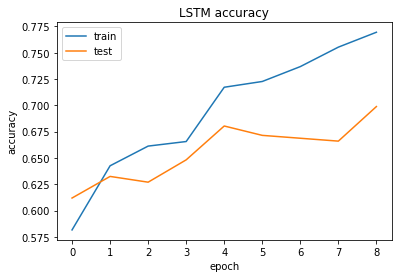

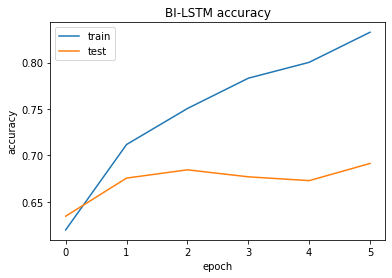

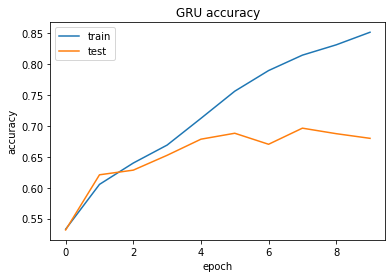

In [75]:
import matplotlib.pyplot as plt


def show_results(history, title):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_results(lstm_result,"LSTM")
show_results(bi_lstm_result,"BI-LSTM")
show_results(gru_result,"GRU")
# seems bidirectional LSTM performs better, will use that

['tech',
 'roundup',
 'earnings',
 'results',
 'show',
 'mixed',
 'messages',
 'across',
 'the',
 'industry',
 'nyse',
 'ibm']